In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import scipy.stats as stats
import cartopy.crs as ccrs
# import pygrib
# import cfgrib
import stormeunice as eun
import warnings
import glob

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

In [37]:
def preproc_ds(ds):
    """
    Main pre-processing function
    Writtten by Nick Leach.

    Input:
    ------

    Output:
    -------
    """

    ## accumulated variables & scaling factors
    accumulated_vars = {'tp':60 * 60 * 24 * 1e3,'ttr':1,'tsr':1,'str':1,'ssr':1,'e':1}
    accumulated_var_newunits = {'tp':'mm day$^{-1}$','ttr':'W m$^{-2}$','tsr':'W m$^{-2}$','str':'W m$^{-2}$','ssr':'W m$^{-2}$','e':'m s$^{-1}$'}


    ds = ds.copy().squeeze()
    fname = ds.encoding['source'].split('/')[-1].split('.')[0]
    expver = fname.split('_')[0]
    ds = ds.expand_dims({'experiment':[expver]})

    # set up aux data
    inidate = pd.to_datetime(ds.time[0].values)
    
    # expand dimensions to include extra info
    if not 'hDate' in ds:
        ds = ds.expand_dims({'inidate':[inidate]})
        
    if not 'number' in ds:
        ds = ds.expand_dims({'number':[0]})
        
    # put time dimension at front
    ds = ds.transpose('time',...)
    
    ds = ds.copy(deep=True)
    # convert accumulated variables into instantaneous
    for var,sf in accumulated_vars.items():
        if var in ds.keys():
            ds[var].loc[dict(time =ds.time[1:])] = 0  #eun.data.Data.accum2rate(ds[var]) * sf
            # set first value to equal zero [since it should be zero... but isn't always]
            ds[var].loc[dict(time=ds.time[0])] = 0
            ds[var].attrs['units'] = accumulated_var_newunits[var]
            
    return ds

# Import data

In [2]:
# EPS

eps = eun.data.Data.get_eps_data()
eps_GUST = eps.fg10.sel(latitude=slice(61,49),longitude=slice(-11,2)).resample(time='1d').max().load()

In [9]:
# ERA5

era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(61,49),longitude=slice(-11,2)).resample(time='1d').max().load()

In [10]:
# MIDAS observational data

MIDAS_station_info = pd.read_csv('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MIDAS/MIDAS_station_info.csv',index_col=0)
MIDAS_station_info['Station_name'] = MIDAS_station_info.Station_name.str.split('\n',expand=True)[0].str.strip()

def get_MIDAS_stations_near(lat,lon,n=1):
    
    dlat = np.deg2rad(MIDAS_station_info.Latitude - lat)
    dlon = np.deg2rad(MIDAS_station_info.Longitude - lon)
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat) * np.cos(MIDAS_station_info.Latitude) * np.sin(dlon/2.0)**2
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        D = np.arcsin(np.sqrt(a))
    
    return MIDAS_station_info.loc[D.sort_values().index[:n],'src_id'].values

In [11]:
MIDAS_2022 = pd.read_csv('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MIDAS/wind/midas_wind_202201-202212.txt',
            names=[x.strip() for x in pd.read_csv('https://dap.ceda.ac.uk/badc/ukmo-midas/metadata/table_structures/WMTB.txt',header=None).values.flatten()])

MIDAS_2022 = MIDAS_2022.apply(lambda x: x.replace(' ',np.nan).astype(float)*0.514444 if x.name[-5:]=='SPEED' else x)
MIDAS_2022['OB_END_TIME'] = pd.to_datetime(MIDAS_2022.OB_END_TIME)

/tmp/user/27529/ipykernel_30450/1519396007.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  MIDAS_2022 = pd.read_csv('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MIDAS/wind/midas_wind_202201-202212.txt',


In [12]:
MIDAS_2022_GUST = MIDAS_2022[['OB_END_TIME','SRC_ID','MAX_GUST_SPEED']]
MIDAS_2022_GUST = MIDAS_2022_GUST.groupby('SRC_ID').resample('1d',on='OB_END_TIME').max().dropna()
MIDAS_2022_GUST[['Latitude','Longitude']] = MIDAS_station_info.set_index('src_id').loc[MIDAS_2022_GUST.SRC_ID.astype(int),['Latitude','Longitude']].values

# Stamp plot differences

# Plumes of wind gusts

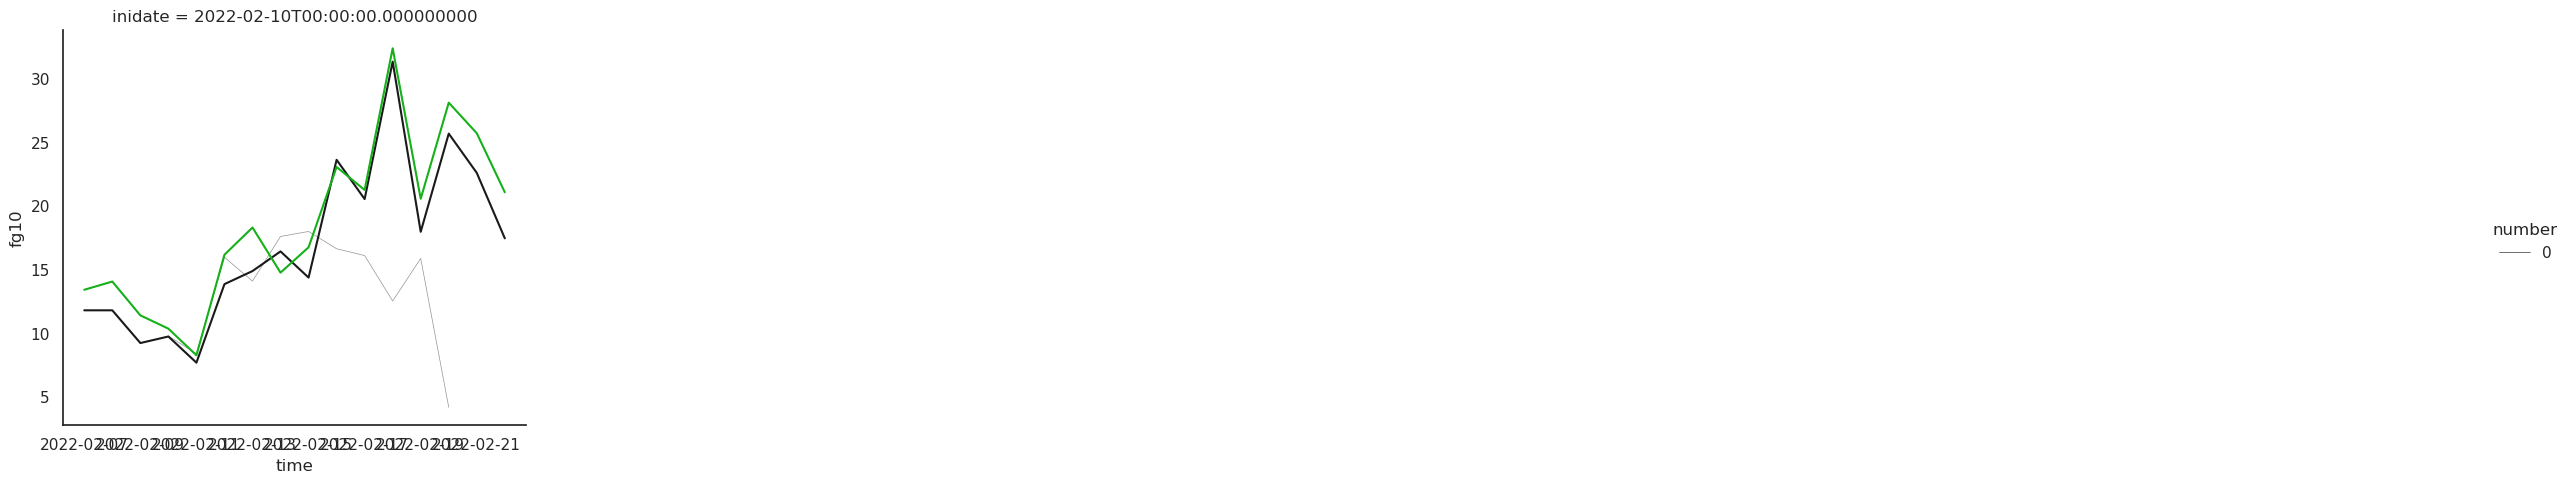

In [15]:
g = sns.relplot(data=eps_GUST.sel(latitude=51.48,longitude=-0.449,method='nearest').to_dataframe().reset_index(),x='time',y='fg10',col='inidate',size='number',sizes=(0.5,0.5),col_wrap=5,kind='line',color='xkcd:grey')

g.map(lambda x, **kwargs: sns.lineplot(data=MIDAS_2022_GUST.loc[(get_MIDAS_stations_near(lat=51.48,lon=-0.449,n=1),slice('2022-02-07','2022-02-22')),:].MAX_GUST_SPEED.reset_index(),x='OB_END_TIME',y='MAX_GUST_SPEED',**kwargs),'time',color='k',zorder=5,lw=1.5)

g.map(lambda x, **kwargs: sns.lineplot(data=era5_GUST.sel(latitude=51.48,longitude=-0.449,method='nearest').to_dataframe().reset_index(),x='time',y='fg10',**kwargs),'time',color='xkcd:green',zorder=5,lw=1.5)

#plt.savefig('../../Output/Figures/inidate-selection/HEATHROW-fg10-plume.png')